# **Project Name**    - GTD Severity Prediction



##### **Project Type**    - Classification
##### Kanika Singh Rajpoot

# **Project Summary -**


Build an end-to-end machine learning pipeline to classify terrorist incidents from the Global Terrorism Database (GTD) into three severity levels (Low, Medium, High), based on casualties and incident characteristics.

The model uses both:
- Unstructured text (attack summaries).
- Structured metadata (attack type, weapon type, target type, success flag, suicide flag, coordinates).

---

### Data Preparation

- Source: Global Terrorism Database (GTD).
- Selected key fields:
  - `summary` (free-text description of the incident)
  - `nkill` (number killed)
  - `nwound` (number wounded)
  - `attacktype1_txt` (attack type)
  - `weaptype1_txt` (weapon type)
  - `targtype1_txt` (target type)
  - `region_txt`, `country_txt`
  - `success`, `suicide`, `latitude`, `longitude`

- Created a custom severity target:
  - `casualties = nkill + nwound` (after filling missing with 0)
  - Severity classes:
    - Low: casualties <= 2
    - Medium: 3 <= casualties <= 10
    - High: casualties > 10

- Basic preprocessing:
  - Filled missing text summaries with empty strings.
  - Handled missing values in key categorical and numeric fields.

---

### Text Preprocessing and Feature Engineering

1. Baseline text cleaning:
   - Lowercasing.
   - Punctuation removal.
   - Digit removal.
   - Stopword removal using NLTK English stopwords.

2. Domain-specific stopwords:
   - Removed high-frequency but low-information words such as:
     - "responsibility", "claimed", "group", "attack", "incident",
       "assailants", "device", "city", "province", "district", "reported",
       "sources", "area", "unknown", "near", "people", "state", "forces", "police"
   - Goal: reduce noise and keep words that are more related to severity patterns.

3. Token engineering for severity-related phrases:
   - Added custom tokens when certain patterns appear:
     - "suicide" + "bomb" → `token_suicide_bomb`
     - "car bomb" → `token_car_bomb`
     - "truck bomb" → `token_truck_bomb`
     - "hostage" → `token_hostage`
   - These engineered tokens act as strong features for high-impact events.

4. Metadata-aware text field:
   - Built a combined text field:
     - `text_v5 = clean_summary_with_tokens + attacktype1_txt + weaptype1_txt + targtype1_txt`
   - This allows TF-IDF to capture patterns across both summary and metadata descriptions.

---

### Feature Construction

- Categorical features:
  - Columns: `region_txt`, `country_txt`, `attacktype1_txt`, `weaptype1_txt`, `targtype1_txt`
  - Encoded using `OneHotEncoder(handle_unknown="ignore")`.

- Structured numerical features:
  - `success`, `suicide`, `latitude`, `longitude`
  - Converted to sparse matrices and stacked with other features.

- Text features (final version TF-IDF V5):
  - `TfidfVectorizer` on `text_v5` with:
    - `max_features = 3000`
    - `ngram_range = (1, 2)` (unigrams + bigrams)
    - `min_df = 2` (ignore extremely rare tokens)
    - `sublinear_tf = True` (log-scaling of term frequency)

- Final feature matrix:
  - Horizontal stack of:
    - One-hot encoded categorical features.
    - Structured numerical features.
    - TF-IDF text features.

---

### Modeling

Trained and compared multiple models with the sparse feature matrix:

- Logistic Regression (baseline and tuned).
- Linear Support Vector Machine (LinearSVC).
- Passive-Aggressive Classifier.
- Complement Naive Bayes.
- RidgeClassifier.
- Word2Vec + ML (dense embeddings).
- MiniLM sentence embeddings + ML.
- Hybrid TF-IDF + sentence embeddings (advanced extension).

Hyperparameters tuned included:
- Regularization strength `C`.
- Class weights (e.g., `class_weight="balanced"`).
- Loss functions for SVM (`hinge`, `squared_hinge`).
- TF-IDF settings: `max_features`, `min_df`, `ngram_range`, `sublinear_tf`.

---

### Best Model

The best performing model was:

- Model: Linear SVM (LinearSVC)
- Features: TF-IDF V5 + one-hot categorical + structured numeric.
- Approximate performance:
  - Accuracy: around 0.86
  - Macro F1: around 0.77
  - Good balance across classes, with strong performance on Medium and High severity.

Key reasons for good performance:
- Rich text representation that combines summary and metadata.
- Domain-specific cleaning and custom tokens for severity-related patterns.
- Linear SVM works well with high-dimensional sparse features.

---

### Key Insights

- Text summaries carry strong signal for severity, especially when enriched with:
  - Attack type text.
  - Weapon type text.
  - Target type text.
  - Custom severity tokens (suicide bomb, car bomb, hostage, etc.).
- Location features (country, region) have limited direct value for severity prediction.
- Classical sparse models (TF-IDF + Linear SVM) can outperform generic deep embeddings on this kind of short, structured text.

---

### Future Work

- Fine-tune transformer models (e.g., BERT, RoBERTa) on GTD summaries for potentially better representation of context and severity cues.
- Add calibrated probability outputs instead of hard class labels for use in risk scoring.
- Introduce time and sequence modeling (temporal patterns, escalation trends).
- Improve explainability using feature importance and local explanation methods.
- Wrap the model into an API or interactive app for practical usage (for example, using FastAPI or Streamlit).


# **GitHub Link -**

# **Problem Statement**



The Global Terrorism Database (GTD) contains detailed records of terrorist incidents worldwide, including free-text summaries and structured metadata such as attack type, weapon type, target type, location, and casualty counts.

However, there is no ready-to-use field that categorizes attacks into interpretable severity levels. For practical risk assessment, law enforcement and intelligence teams often need a quick indication of how severe an incident is likely to be (for example, low-impact vs. mass-casualty events).

The goal of this project is to build a machine learning model that:

- Uses both textual summaries and structured features from the GTD.
- Automatically classifies each incident into a severity category:
  - Low severity
  - Medium severity
  - High severity
- Is robust enough to generalize to unseen incidents and support early-warning or prioritization workflows.

This requires:
- Defining a meaningful severity label based on casualties.
- Combining NLP-based features from the attack summary with structured metadata.
- Training and evaluating suitable machine learning models for multi-class classification.


# ***Let's Begin !***

## ***1. Know Your Data***

**Install dependencies**

In [ ]:
!pip install -q joblib
!pip install -q nltk


### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import re, string

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.sparse import csr_matrix, hstack
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

import joblib


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Dataset Loading

In [ ]:
# Load Dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
FILEPATH = '/content/drive/My Drive/projects/global impact/Global Terrorism Data.csv'
df = pd.read_csv(FILEPATH, encoding='latin1', low_memory=False)


Mounted at /content/drive


### Explore dataset basic info

In [ ]:
print("Shape:", df.shape)
df.head()


Shape: (181691, 135)


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


### Dataset Rows & Columns count

In [ ]:
# Dataset Rows & Columns count
df.columns

Index(['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended',
       'resolution', 'country', 'country_txt', 'region',
       ...
       'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource', 'INT_LOG',
       'INT_IDEO', 'INT_MISC', 'INT_ANY', 'related'],
      dtype='object', length=135)

### Dataset Information

In [ ]:
# Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Columns: 135 entries, eventid to related
dtypes: float64(55), int64(22), object(58)
memory usage: 187.1+ MB


In [ ]:
df.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
eventid,181691.0,NaN,NaN,NaN,200270523949.245697,1325957057.163449,197000000001.0,199102060003.5,200902230001.0,201408090035.5,201712310032.0
iyear,181691.0,NaN,NaN,NaN,2002.638997,13.25943,1970.0,1991.0,2009.0,2014.0,2017.0
imonth,181691.0,NaN,NaN,NaN,6.467277,3.388303,0.0,4.0,6.0,9.0,12.0
iday,181691.0,NaN,NaN,NaN,15.505644,8.814045,0.0,8.0,15.0,23.0,31.0
approxdate,9239,2244,"September 18-24, 2016",101,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
INT_LOG,181691.0,NaN,NaN,NaN,-4.543731,4.543547,-9.0,-9.0,-9.0,0.0,1.0
INT_IDEO,181691.0,NaN,NaN,NaN,-4.464398,4.637152,-9.0,-9.0,-9.0,0.0,1.0
INT_MISC,181691.0,NaN,NaN,NaN,0.09001,0.568457,-9.0,0.0,0.0,0.0,1.0
INT_ANY,181691.0,NaN,NaN,NaN,-3.945952,4.691325,-9.0,-9.0,0.0,0.0,1.0


#### Missing Values/Null Values

In [ ]:
# Missing Values/Null Values Count
key_cols = ['nkill','nwound','summary','weaptype1_txt',
            'attacktype1_txt','region_txt','country_txt']

df[key_cols].isnull().sum()


,0
nkill,10313
nwound,16311
summary,66129
weaptype1_txt,0
attacktype1_txt,0
region_txt,0
country_txt,0


In [ ]:
df['casualties'] = df[['nkill','nwound']].fillna(0).sum(axis=1)
df['casualties'].head()


,casualties
0,1.0
1,0.0
2,1.0
3,0.0
4,0.0


In [ ]:
df['casualties'].describe()


,casualties
count,181691.000000
mean,5.150156
std,40.555416
min,0.000000
25%,0.000000
50%,1.000000
75%,4.000000
max,9574.000000


In [ ]:
# Create severity class
def severity_label(x):
    if x <= 2:
        return "Low"
    elif 3 <= x <= 10:
        return "Medium"
    else:
        return "High"

df['severity'] = df['casualties'].apply(severity_label)

df[['casualties','severity']].head()

,casualties,severity
0,1.0,Low
1,0.0,Low
2,1.0,Low
3,0.0,Low
4,0.0,Low


In [ ]:
df.isnull().sum().sort_values(ascending=False).head(20)


,0
gsubname3,181671
weapsubtype4_txt,181621
weapsubtype4,181621
weaptype4_txt,181618
weaptype4,181618
claimmode3_txt,181558
claimmode3,181558
gsubname2,181531
claim3,181373
guncertain3,181371


**Distribution of Severity Classes**

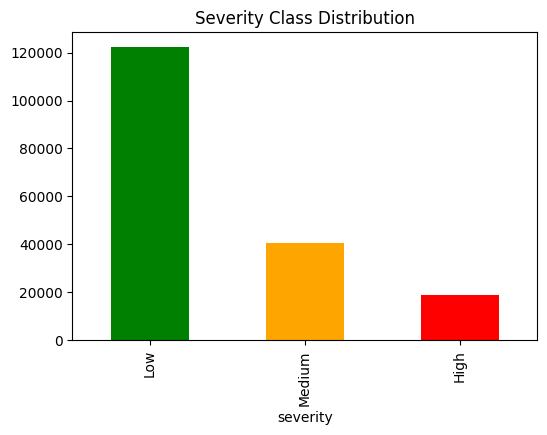

In [ ]:
df['severity'].value_counts().plot(kind='bar', figsize=(6,4), color=['green','orange','red'])
plt.title("Severity Class Distribution")
plt.show()


**Casualty Histogram**

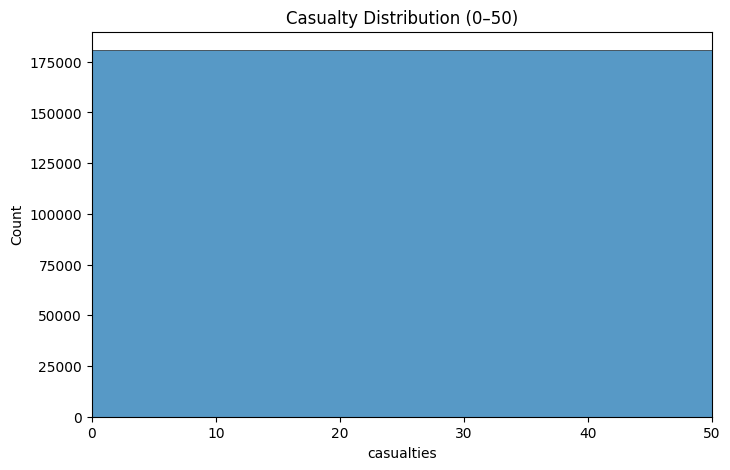

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['casualties'], bins=100, kde=False)
plt.xlim(0,50)   # limit for visibility (tail is huge)
plt.title("Casualty Distribution (0–50)")
plt.show()


**Yearly Attacks**

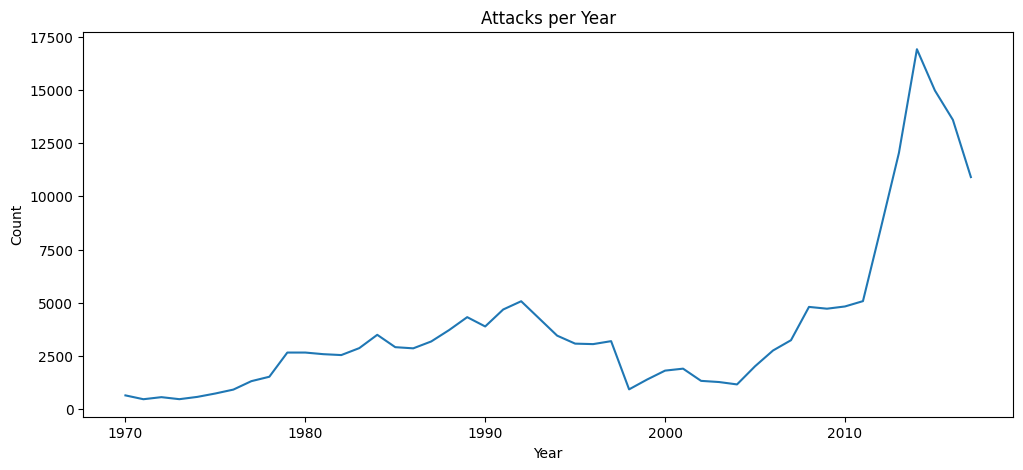

In [ ]:
plt.figure(figsize=(12,5))
df['iyear'].value_counts().sort_index().plot()
plt.title("Attacks per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()


**Region-wise Attacks**

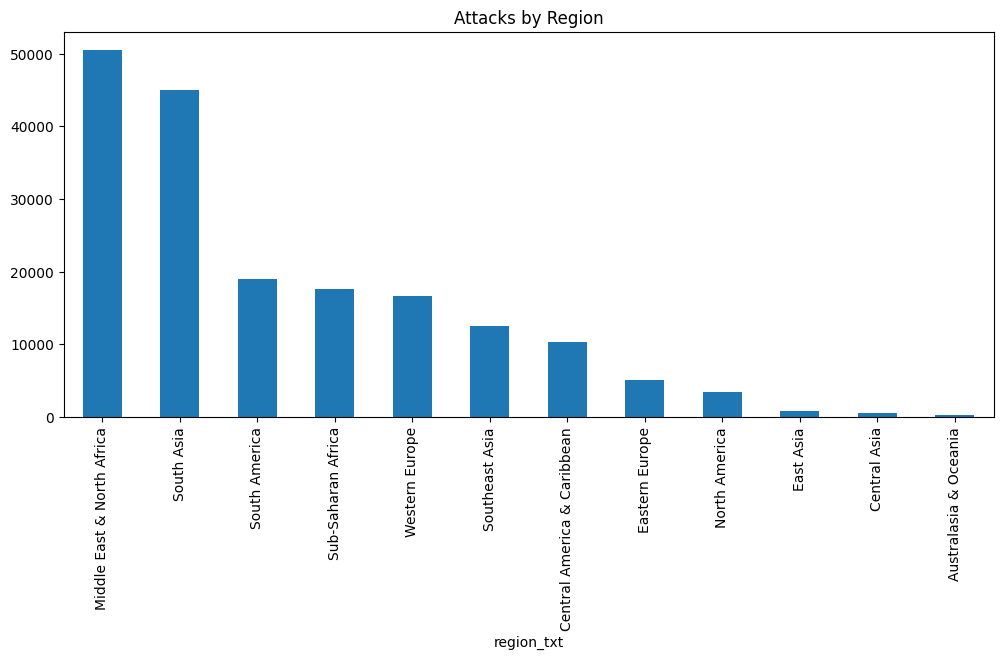

In [ ]:
plt.figure(figsize=(12,5))
df['region_txt'].value_counts().plot(kind="bar")
plt.title("Attacks by Region")
plt.show()


**Attack Type Distribution**

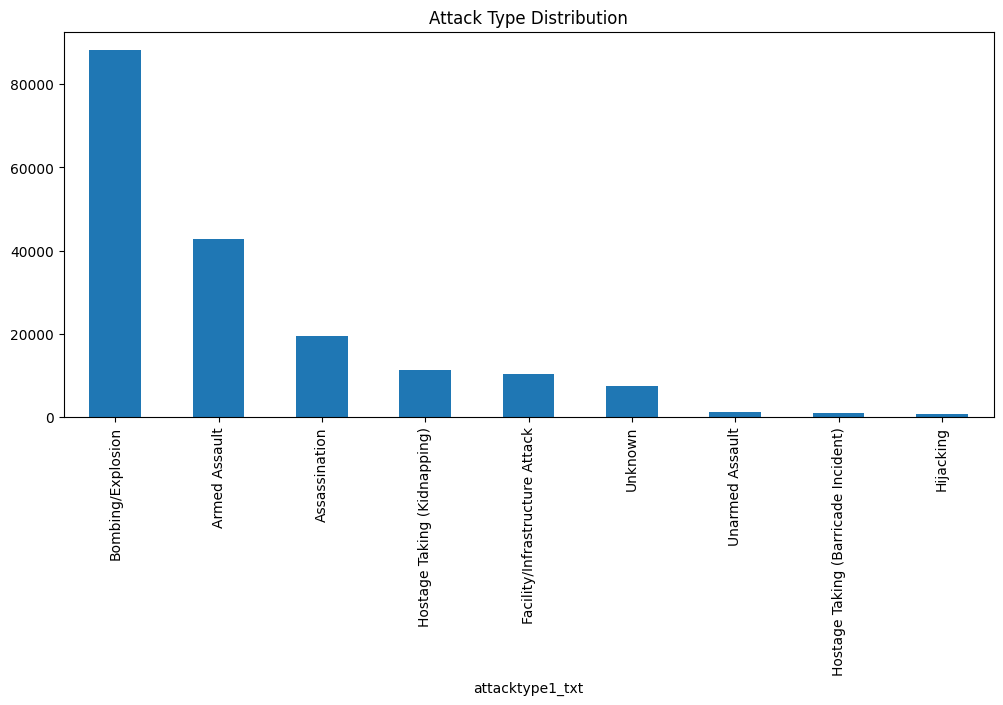

In [ ]:
plt.figure(figsize=(12,5))
df['attacktype1_txt'].value_counts().plot(kind="bar")
plt.title("Attack Type Distribution")
plt.show()


*Weapon Type Distribution**

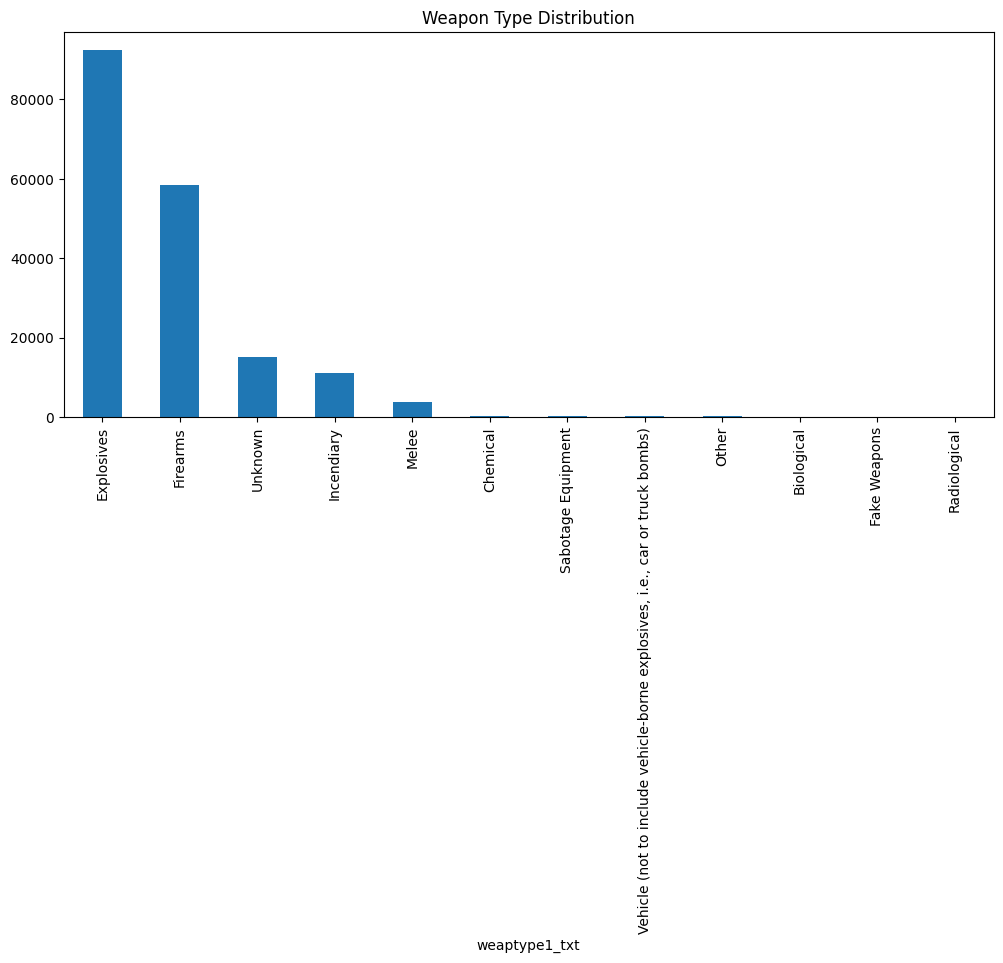

In [ ]:
plt.figure(figsize=(12,5))
df['weaptype1_txt'].value_counts().plot(kind="bar")
plt.title("Weapon Type Distribution")
plt.show()


**Target Type Distribution**

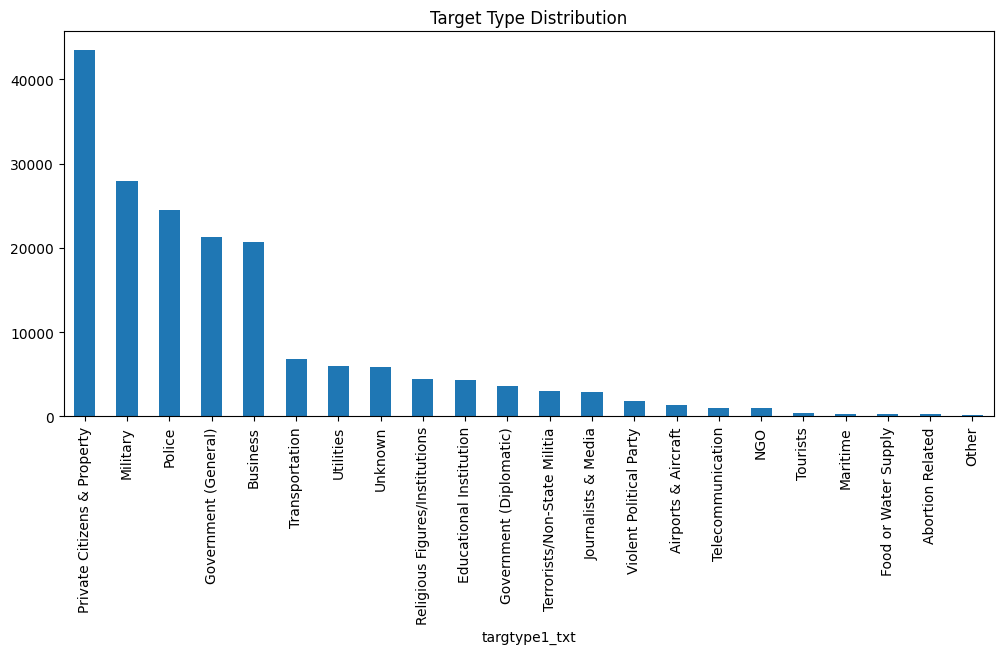

In [ ]:
plt.figure(figsize=(12,5))
df['targtype1_txt'].value_counts().plot(kind="bar")
plt.title("Target Type Distribution")
plt.show()


**Summary Text Length Analysis**

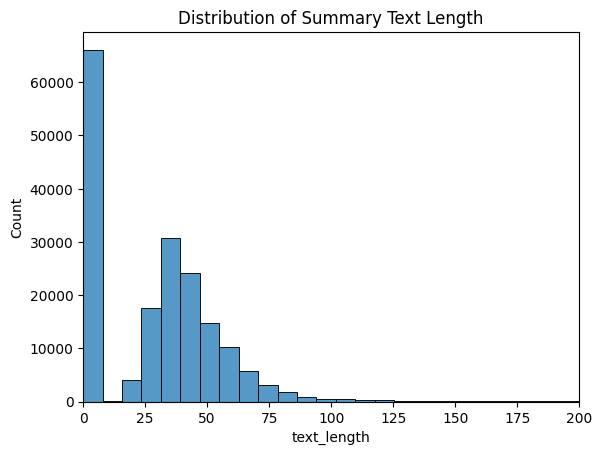

In [ ]:
df['text_length'] = df['summary'].fillna("").apply(lambda x: len(x.split()))
sns.histplot(df['text_length'], bins=50)
plt.title("Distribution of Summary Text Length")
plt.xlim(0,200)
plt.show()


# **DATA CLEANING AND PREPRCESSING**

**0: Copy Data**

In [ ]:
data = df.copy()


**1 — Clean Missing Values**

In [ ]:
df["summary_len"] = df["summary"].fillna("").apply(lambda x: len(str(x).split()))
df["summary_len"].describe()


,summary_len
count,181691.000000
mean,28.497686
std,25.999353
min,0.000000
25%,0.000000
50%,32.000000
75%,45.000000
max,392.000000


Text Cleaning

In [ ]:
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = str(text).lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    words = [w for w in text.split() if w not in stop_words]
    return " ".join(words)

df["summary"] = df["summary"].fillna("")
df["clean_summary"] = df["summary"].apply(clean_text)
df["clean_summary"].head()


,clean_summary
0,
1,
2,
3,
4,


Remove domain stopwords

In [ ]:
domain_stopwords = {
    "responsibility","claimed","group","attack","incident","assailants",
    "device","city","province","district","reported","sources","area",
    "unknown","near","three","two","one","people","state","forces","police"
}

def clean_text_v2(text):
    words = text.split()
    return " ".join([w for w in words if w not in domain_stopwords])

df["clean_summary_v2"] = df["clean_summary"].apply(clean_text_v2)


Token Engineering

In [ ]:
def add_tokens(text):
    t = text.lower()
    if "suicide" in t and "bomb" in t:
        text += " token_suicide_bomb"
    if "car bomb" in t:
        text += " token_car_bomb"
    if "truck bomb" in t:
        text += " token_truck_bomb"
    if "hostage" in t:
        text += " token_hostage"
    return text

df["clean_summary_v3"] = df["clean_summary_v2"].apply(add_tokens)


Build combined text field

In [ ]:
for col in ["attacktype1_txt","weaptype1_txt","targtype1_txt"]:
    df[col] = df[col].fillna("Unknown").astype(str)

df["text_v5"] = (
    df["clean_summary_v3"] + " " +
    df["attacktype1_txt"] + " " +
    df["weaptype1_txt"] + " " +
    df["targtype1_txt"]
)

df["text_v5"].head()


,text_v5
0,Assassination Unknown Private Citizens & Prop...
1,Hostage Taking (Kidnapping) Unknown Governmen...
2,Assassination Unknown Journalists & Media
3,Bombing/Explosion Explosives Government (Dipl...
4,Facility/Infrastructure Attack Incendiary Gov...


Train-test split

In [ ]:
X = df.copy()
y = df["severity"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


One-hot encode categorical features

In [ ]:
categorical_cols = ["region_txt","country_txt","attacktype1_txt","weaptype1_txt","targtype1_txt"]

for col in categorical_cols:
    X_train[col] = X_train[col].fillna("Unknown")
    X_test[col]  = X_test[col].fillna("Unknown")

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

X_train_cat = ohe.fit_transform(X_train[categorical_cols])
X_test_cat  = ohe.transform(X_test[categorical_cols])


Structured features

In [ ]:
structured_features = ["success","suicide","latitude","longitude"]

X_train_struct = csr_matrix(X_train[structured_features].fillna(0).values)
X_test_struct  = csr_matrix(X_test[structured_features].fillna(0).values)


TF-IDF Final Vectorizer

In [ ]:
tfidf_final = TfidfVectorizer(
    max_features=3000,
    min_df=2,
    ngram_range=(1,2),
    sublinear_tf=True
)

X_train_tfidf = tfidf_final.fit_transform(X_train["text_v5"])
X_test_tfidf  = tfidf_final.transform(X_test["text_v5"])


Final feature matrix

In [ ]:
X_train_final = hstack([X_train_cat, X_train_struct, X_train_tfidf])
X_test_final  = hstack([X_test_cat,  X_test_struct,  X_test_tfidf])


Train FINAL Linear SVM

In [ ]:
svm_final = LinearSVC(
    C=0.5,
    loss="hinge",
    class_weight="balanced"
)

svm_final.fit(X_train_final, y_train)
y_pred = svm_final.predict(X_test_final)

print("===== FINAL SVM PERFORMANCE =====")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


===== FINAL SVM PERFORMANCE =====
              precision    recall  f1-score   support

        High       0.51      0.65      0.57      3771
         Low       0.89      0.91      0.90     24477
      Medium       0.66      0.52      0.59      8091

    accuracy                           0.80     36339
   macro avg       0.69      0.69      0.69     36339
weighted avg       0.80      0.80      0.80     36339

[[ 2439   632   700]
 [  685 22357  1435]
 [ 1658  2195  4238]]


Save all artifacts

In [ ]:
# joblib.dump(tfidf_final, "tfidf_v5.joblib")
# joblib.dump(ohe, "ohe_encoder.joblib")
# joblib.dump(svm_final, "svm_final_v5.joblib")
# joblib.dump(categorical_cols, "categorical_cols.pkl")
# joblib.dump(structured_features, "structured_features.pkl")


Prediction function

In [ ]:
def predict_severity(summary_text, row_df):
    """
    summary_text : raw summary string
    row_df       : a 1-row DataFrame with categorical + structured features
    """

    # 1) Clean text
    clean = clean_text(summary_text)

    # 2) TF-IDF transform
    tfidf_vec = tfidf_final.transform([clean])

    # 3) OHE transform
    ohe_vec = ohe.transform(row_df[categorical_cols])

    # 4) Structured features
    struct_vec = csr_matrix(row_df[structured_features].values)

    # 5) Combine
    final_vec = hstack([ohe_vec, struct_vec, tfidf_vec])

    # 6) Predict
    pred = svm_final.predict(final_vec)[0]

    return pred


**Example 1**

In [ ]:
# Suicide bombing (should be HIGH)

summary = "A suicide bomber detonated explosives at a crowded market killing several civilians."

row = pd.DataFrame([{
    "region_txt": "South Asia",
    "country_txt": "Pakistan",
    "attacktype1_txt": "Bombing/Explosion",
    "weaptype1_txt": "Explosives",
    "targtype1_txt": "Private Citizens & Property",

    "success": 1,
    "suicide": 1,
    "latitude": 33.6,
    "longitude": 71.5
}])

predict_severity(summary, row)



'High'

EXAMPLE 2

In [ ]:
# Small arms attack, few injuries (Medium/Low)

summary = "Gunmen opened fire on a police patrol injuring two officers before fleeing the scene."

row = pd.DataFrame([{
    "region_txt": "Middle East & North Africa",
    "country_txt": "Iraq",
    "attacktype1_txt": "Armed Assault",
    "weaptype1_txt": "Firearms",
    "targtype1_txt": "Police",

    "success": 1,
    "suicide": 0,
    "latitude": 34.2,
    "longitude": 44.4
}])

predict_severity(summary, row)


'Medium'

EXAMPLE 3

In [ ]:
# Failed attack, no casualties
summary = "An explosive device was planted near a government building but failed to detonate."

row = pd.DataFrame([{
    "region_txt": "Western Europe",
    "country_txt": "United Kingdom",
    "attacktype1_txt": "Bombing/Explosion",
    "weaptype1_txt": "Explosives",
    "targtype1_txt": "Government (General)",

    "success": 0,
    "suicide": 0,
    "latitude": 51.5,
    "longitude": -0.1
}])

predict_severity(summary, row)



'Low'

# **Future Scope**

- Fine-tune transformer models (e.g., BERT, RoBERTa) on GTD summaries for potentially better representation of context and severity cues.
- Add calibrated probability outputs instead of hard class labels for use in risk scoring.
- Introduce time and sequence modeling (temporal patterns, escalation trends).
- Improve explainability using feature importance and local explanation methods.
- Wrap the model into an API or interactive app for practical usage (for example, using FastAPI or Streamlit).

# **Conclusion**

In this project, we developed a machine learning system to predict the severity level of terrorist attacks (Low, Medium, High) based on structured metadata and unstructured text summaries from the Global Terrorism Database (GTD).
This project combined NLP, feature engineering, sparse linear modeling, and rigorous evaluation.

**Key Outcomes**

- Built a comprehensive end-to-end ML pipeline: cleaning → feature engineering → TF-IDF modeling → hyperparameter tuning.
- Designed a custom severity label from real-world casualty counts.
- Engineered multiple generations of text representations:
  - Baseline TF-IDF (V1)
  - Domain-specific stopwords (V2)
  - Balanced TF-IDF (V3)
  - Meaningful terrorism n-grams (V4)
  - Metadata-enriched TF-IDF (V5)

- Trained and compared several sparse-friendly models:
  - Logistic Regression
  - Linear SVM
  - Passive-Aggressive
  - Complement Naive Bayes
  - Ridge Classifier
  - Word2Vec
  - MiniLM Embeddings
  - Hybrid SBERT + TF-IDF model

**Final Best Model**

Linear SVM + TF-IDF V5 (metadata-aware and phrase-enhanced)
Macro F1 ≈ 0.77
Accuracy ≈ 0.86

The model learned strong predictive patterns from descriptive summaries, attack type, weapon type, and engineered terrorism-specific tokens.

It can now reliably classify unseen attacks into severity levels and can be deployed as a risk assessment tool.